In [1]:
import sys,time
sys.path.append('../')
from smodels.experiment.defaultFinalStates import finalStates
from smodels.share.models.mssm import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.decomposition.theorySMS import TheorySMS
from smodels.experiment.expSMS import ExpSMS
from smodels.base.genericSMS import GenericSMS
from smodels.base.model import Model
from smodels.base.physicsUnits import fb, GeV, TeV, pb
from smodels.experiment.txnameObj import TxName, TxNameData
from smodels.experiment.infoObj import Info
from smodels.experiment.expAuxiliaryFuncs import bracketToProcessStr, maximal_matching
from collections import OrderedDict
from smodels.experiment.exceptions import SModelSExperimentError as SModelSError
from smodels.base.particleNode import ParticleNode,InclusiveParticleNode
from smodels.base.genericSMS import GenericSMS
from smodels.experiment.expAuxiliaryFuncs import bracketToProcessStr, maximal_matching
from smodels.base.physicsUnits import fb
from itertools import product
from collections import OrderedDict
import numpy as np
import unum
from itertools import product

In [2]:
sms1 = ExpSMS.from_string("[[],[['*']]]",finalState=['HSCP','HSCP'],intermediateState=None,
                        model=finalStates)
sms2 = ExpSMS.from_string("[[['*']],[]]",finalState=['HSCP','HSCP'],intermediateState=None,
                        model=finalStates)

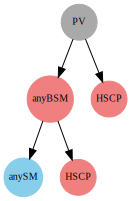

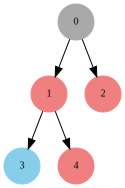

In [3]:
sms1.draw()
sms1.draw(labelAttr='node')

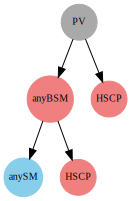

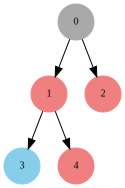

In [4]:
sms2.draw()
sms2.draw(labelAttr='node')

In [5]:
stringSMS = "[[],[['*']]]"
finalState=['HSCP','HSCP']
intermediateState=None
model=finalStates

In [6]:
procString = bracketToProcessStr(stringSMS, finalState=finalState,
                                     intermediateState=intermediateState)
print(procString)

(PV > HSCP,anyBSM(1)),(anyBSM(1) > anySM,HSCP)


In [7]:
decays = procString.replace(" ", "").split("),(")
decays[0] = decays[0][1:]  # Remove trailing parenthesis
decays[-1] = decays[-1][:-1]  # Remove remaining parenthesis

# Split decays into mother and daughters tuples:
decayParticles = []
for dec in decays:
    momStr = dec.split('>')[0].strip()
    daughtersStr = [p.strip() for p in dec.split('>')[1].split(',')]
    decayParticles.append((momStr,daughtersStr))
    
print(decayParticles)

# Build a mapping (particle string > nodeIndex) for all unstable particles:
nodesDict = {}
maxNode = 0
for mom,daughters in decayParticles:
    if mom == 'PV':
        nodeIndex = 0  # PV is always node zero
    elif '(' in mom and ')' in mom:  # Unstable particles should always have a unique numbering
        nodeIndex = eval(mom.split('(')[1].split(')')[0])
    else:
        continue  # Stable particles will have their nodes defined later
    nodesDict[mom] = nodeIndex
    maxNode = max(maxNode,nodeIndex)  # Store highest node index
print(nodesDict)

[('PV', ['HSCP', 'anyBSM(1)']), ('anyBSM(1)', ['anySM', 'HSCP'])]
{'PV': 0, 'anyBSM(1)': 1}


In [8]:
# Add the stable particles to nodesDict
# and create successors dict
successorsStr = {}
for mom,daughters in decayParticles:
    successorsStr[mom] = []
    for ptc in daughters:
        if ptc in nodesDict:
            successorsStr[mom].append(ptc)
            continue
        maxNode = maxNode+1
        # Enumerate the unstable daughter labels, so they are unique
        ptcLabel = '%s(%i)' %(ptc,maxNode)
        nodesDict[ptcLabel] = maxNode
        successorsStr[mom].append(ptcLabel)
        
print(nodesDict)
print(successorsStr)

{'PV': 0, 'anyBSM(1)': 1, 'HSCP(2)': 2, 'anySM(3)': 3, 'HSCP(4)': 4}
{'PV': ['HSCP(2)', 'anyBSM(1)'], 'anyBSM(1)': ['anySM(3)', 'HSCP(4)']}


In [9]:
# Sort successors according to the node index
sortedMoms = list(successorsStr.keys())
sortedSuccessors = OrderedDict()
for mom in sortedMoms:
    sortedDaughters = successorsStr[mom]
    sortedSuccessors[mom] = sortedDaughters
print(sortedMoms)
print(sortedSuccessors)

['PV', 'anyBSM(1)']
OrderedDict([('PV', ['HSCP(2)', 'anyBSM(1)']), ('anyBSM(1)', ['anySM(3)', 'HSCP(4)'])])


In [13]:
# Convert strings to node objects:
nodesObjDict = {}
for ptcStr in nodesDict:
    # Check for inclusive node
    label = ptcStr.split('(')[0]
    if label.lower() == 'inclusive' or label.lower() == 'inclusivenode':
        node = InclusiveParticleNode()
    else:
        # Check for inclusive lists:
        inclusiveList = False
        if label[0] == '*':
            label = label[1:]
            inclusiveList = True
        if model is None:
            particle = label
        else:
            particle = model.getParticle(label=label)
        node = ParticleNode(particle=particle,
                            inclusiveList=inclusiveList)

    # Change key from node index to node object
    nodesObjDict[ptcStr] = node
print(nodesObjDict)

{'PV': PV, 'anyBSM(1)': anyBSM, 'HSCP(2)': HSCP, 'anySM(3)': anySM, 'HSCP(4)': HSCP}


In [17]:
# Create SMS, add all unstable nodes following the sorted order
# and keep track of generated indices
newSMS = ExpSMS()
smsDict = {}
for momStr in sortedSuccessors:
    nodeIndex = newSMS.add_node(nodesObjDict[momStr])
    smsDict[momStr] = nodeIndex
# Add stable nodes and keep track of SMS indices
for ptcStr in nodesObjDict:
    if ptcStr in smsDict:
        continue  # Node has been added
    nodeIndex = newSMS.add_node(nodesObjDict[ptcStr])
    smsDict[ptcStr] = nodeIndex

# Finally add all edges according to successorsDict:
for momStr, daughtersStr in sortedSuccessors.items():
    if not daughtersStr:
        continue
    momIndex = smsDict[momStr]
    print('adding %s -> %s' %(momStr,daughtersStr))
    daughterIndices = [smsDict[d] for d in daughtersStr]
    print('indicies',daughterIndices)
    print(list(product([momIndex],daughterIndices)))
    newSMS.add_edges_from(product([momIndex],daughterIndices))


adding PV -> ['HSCP(2)', 'anyBSM(1)']
indicies [2, 1]
[(0, 2), (0, 1)]
adding anyBSM(1) -> ['anySM(3)', 'HSCP(4)']
indicies [3, 4]
[(1, 3), (1, 4)]


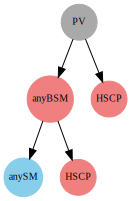

In [12]:
newSMS.draw()